## Import

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models.segmentation as segmentation
import segmentation_models_pytorch as smp
import torchvision.models as models
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as transforms
from albumentations.core.composition import Compose

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Fuctions

## RLE decoding/encoding

In [2]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Model load

In [3]:
# save_dir = "./path/save/resnet50_l2/"  # 모델 저장 디렉토리
# model_name = "deeplabv3_resnet50_l2_trained_epoch{}.pth"  # 모델 파일 이름 패턴

# # 훈련된 모델을 저장하는 함수
# def save_model(model, epoch):
#     save_path = save_dir + model_name.format(epoch)
#     torch.save(model.state_dict(), save_path)
#     print(f"Epoch {epoch} 모델 저장이 완료되었습니다.")

# 모델 불러오는 함수
def load_model(model, load_path):
    state_dict = torch.load(load_path)
    # 이전에 저장된 모델과 현재 모델 간 레이어 일치 여부 확인
    model_dict = model.state_dict()
    new_state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
    model_dict.update(new_state_dict)
    model.load_state_dict(model_dict)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print("모델 불러오기가 완료되었습니다.")

In [4]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False): # transform 전처리하거나 다른 형태로 변환하는데 사용, infer 데이터를 추론 모드로 설정할지 여부
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1] # 해당 인덱스에 위치한 데이터프레임의 두 번째 열(column)에 있는 이미지 경로를 가져옴
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2] # 데이터프레임의 idx 행에서 세 번째 열(column)에 있는 마스크 정보를 가져옴
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1])) # 원래의 마스크 이미지로 변환

        if self.transform:
            augmented = self.transform(image=image, mask=mask) # 이미지와 마스크를 변환
            image = augmented['image'] # 변환된 이미지를 딕셔너리에서 가져와 image 변수에 할당
            mask = augmented['mask'] # 변환된 이미지를 딕셔너리에서 가져와 mask 변수에 할당

        return image, mask

# Train Data Loader

In [5]:
# albumentations 라이브러리를 사용하여 이미지 데이터에 대한 변환(transform) 파이프라인 정의
transform = A.Compose(
    [
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 이미지 픽셀값 정규화
        ToTensorV2() # 이미지를 텐서로 변환
    ]
)

# # 데이터 증강을 위한 transform 파이프라인 정의
# transform = A.Compose(
#     [
#         A.Resize(224, 224),  # 이미지 크기 조정
#         A.RandomCrop(224, 224),  # 랜덤한 위치에서 224x224 크기로 자르기
#         A.RandomRotate90(),  # 90도 회전 (랜덤하게)
#         A.HorizontalFlip(p=0.5),  # 수평 뒤집기 확률 50%
#         A.VerticalFlip(p=0.5),  # 수직 뒤집기 확률 50%
#         A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.7),  # 이동, 크기 조정, 회전
#         A.CLAHE(p=0.2),  # CLAHE를 통한 대비 개선
#         A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, p=0.5),  # Cutout 적용
#         A.Normalize(),  # 이미지 픽셀값 정규화
#         ToTensorV2()  # 이미지를 텐서로 변환
#     ]
# )

# dataset = SatelliteDataset(csv_file='./train.csv', transform=transform) # dataset 불러오기
# dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Test Data Loader

In [6]:
test_dataset = SatelliteDataset(csv_file='./validation.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
print(len(test_dataset))
print(len(test_dataloader))

100
7


# Load Model

In [8]:
# 모델 생성
model = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=False,num_classes=1)

# 저장된 모델의 파라미터 불러오기 (strict=False 옵션 사용)
state_dict = torch.load('./path/save/v3_mobilenet_plus_pspaug/v3_mobilenet_plus_pspaug_trained_epoch48.pth', map_location=torch.device('cpu'))

# 저장된 모델의 클래스 수 (1개의 클래스일 때)
saved_num_classes = 1

# 현재 모델의 클래스 수 (예시로 21로 설정, 실제 사용하는 클래스 수로 수정)
current_num_classes = 1

# 모델의 분류기 레이어 크기 변경
if saved_num_classes != current_num_classes:
    # 모델의 분류기 레이어를 1x1 컨볼루션 레이어로 수정
    model.classifier[4] = torch.nn.Conv2d(256, current_num_classes, kernel_size=(1, 1), stride=(1, 1))
    # 모델의 분류기 레이어를 초기화
    torch.nn.init.xavier_uniform_(model.classifier[4].weight)  # 또는 다른 초기화 방법 사용

# 모델의 파라미터 로드
model.load_state_dict(state_dict, strict=False)

# GPU 사용이 가능한 경우에는 GPU로 데이터 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): Identity()
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 

# Inference

  0%|          | 0/7 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


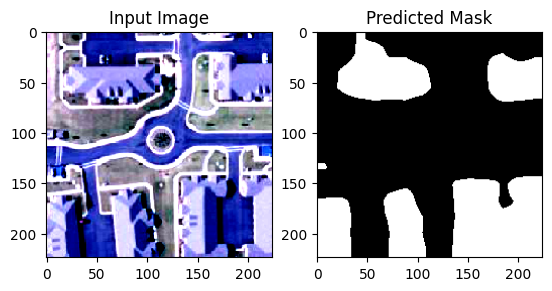

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


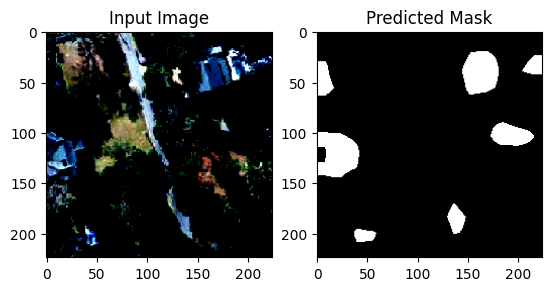

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


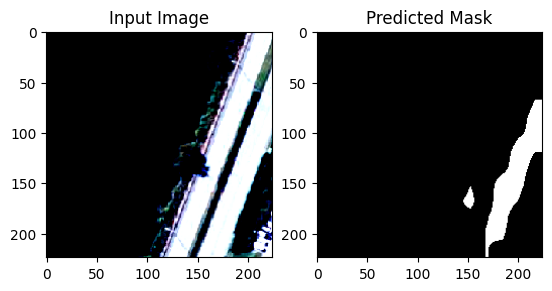

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


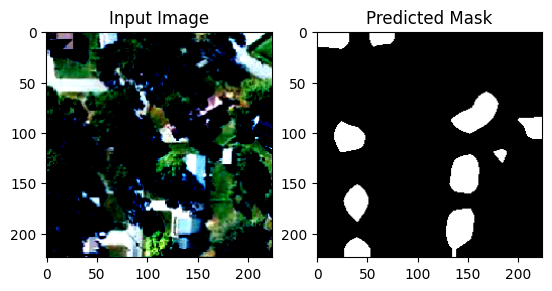

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


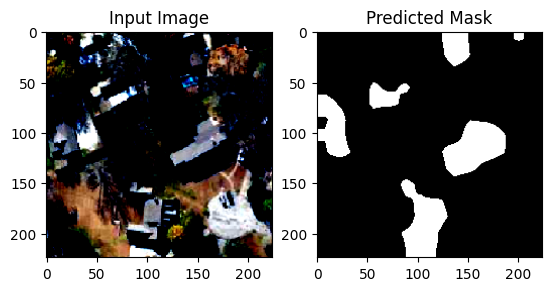

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


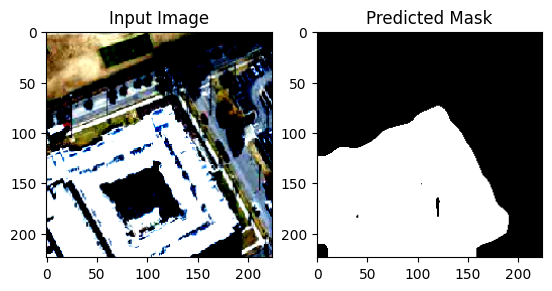

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


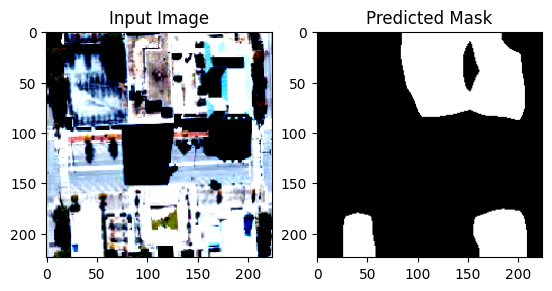

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


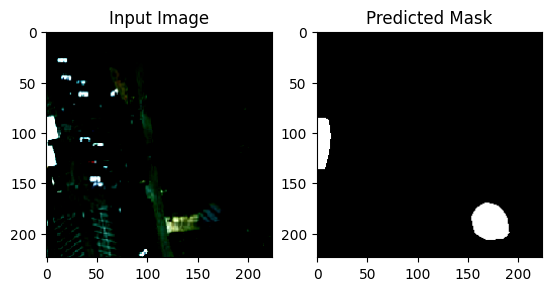

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


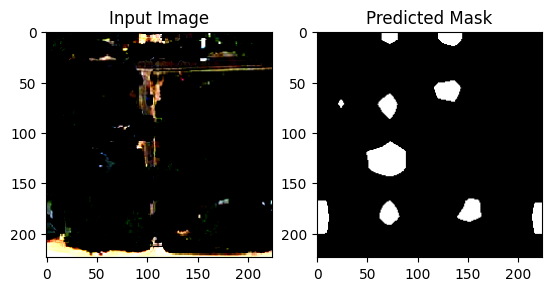

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


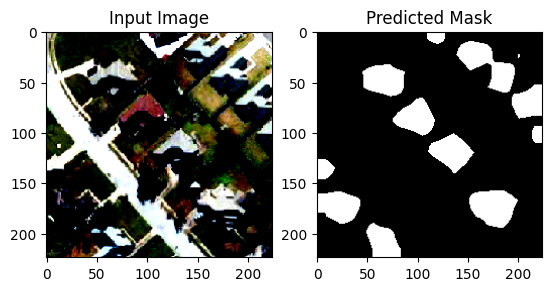

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


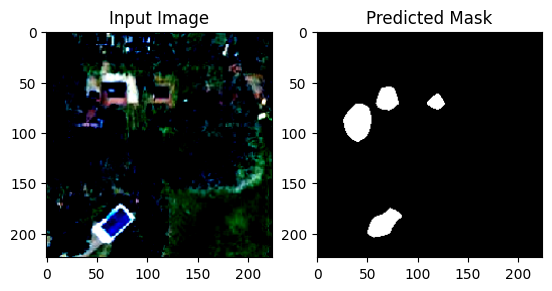

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


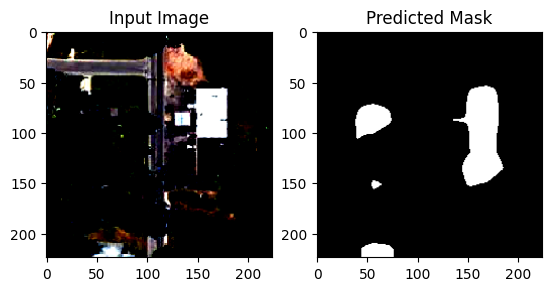

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


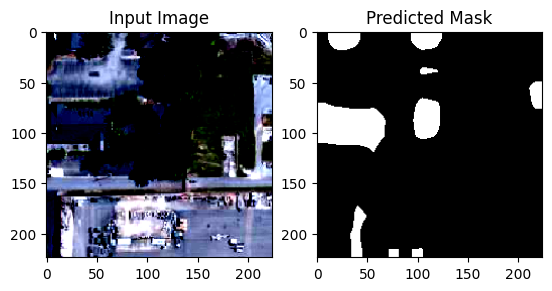

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


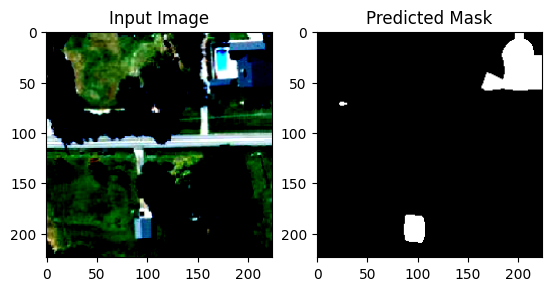

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


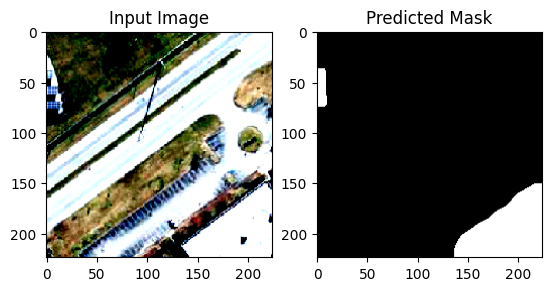

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


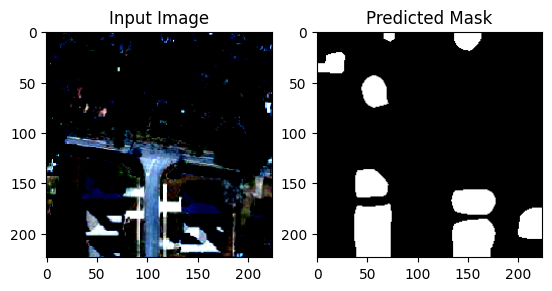

 14%|█▍        | 1/7 [00:03<00:22,  3.80s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


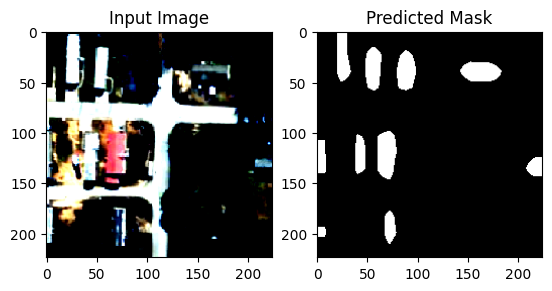

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


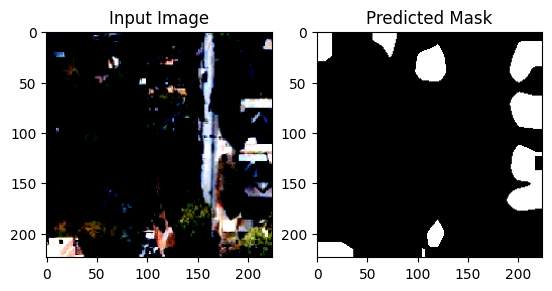

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


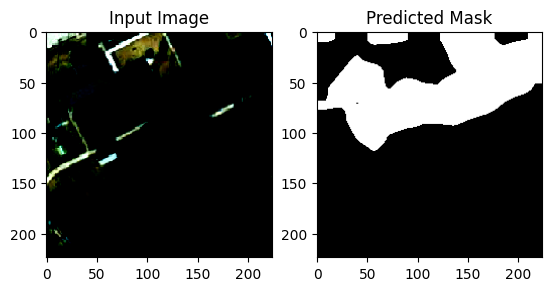

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


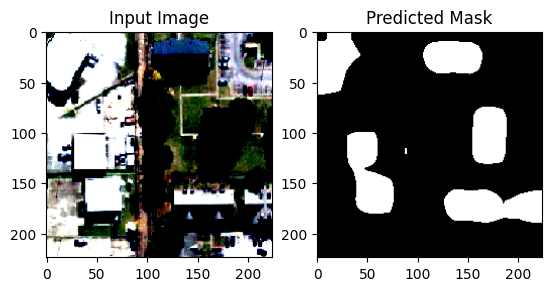

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


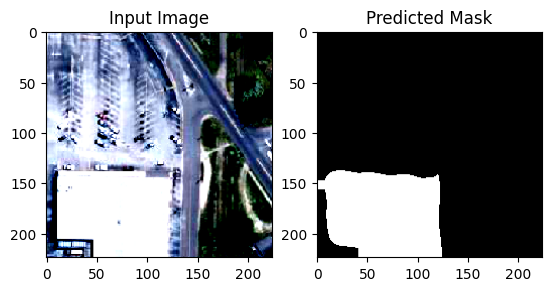

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


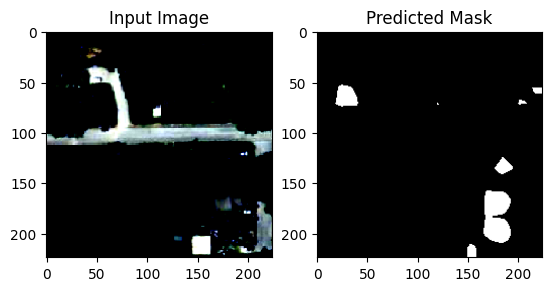

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


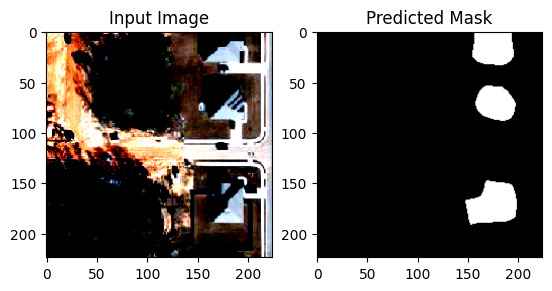

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


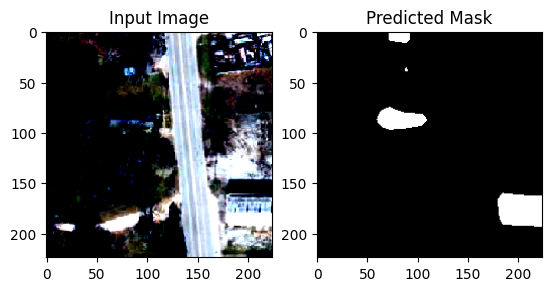

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


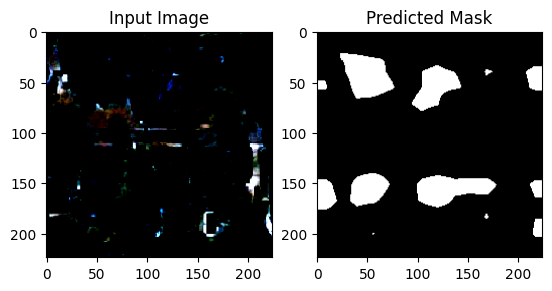

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


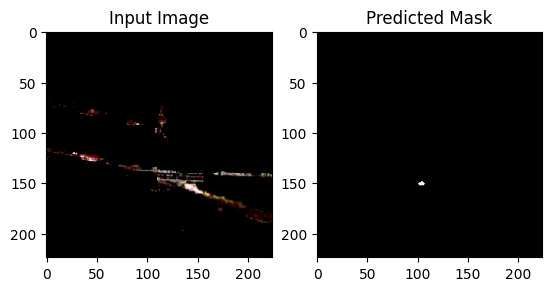

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


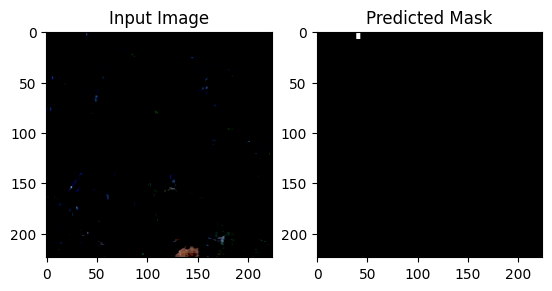

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


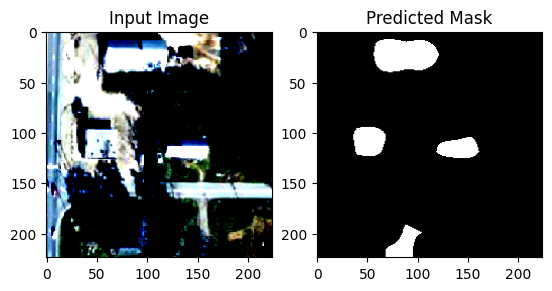

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


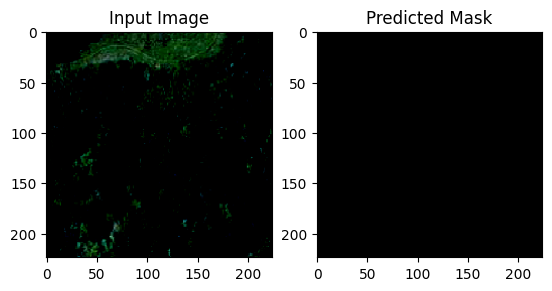

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


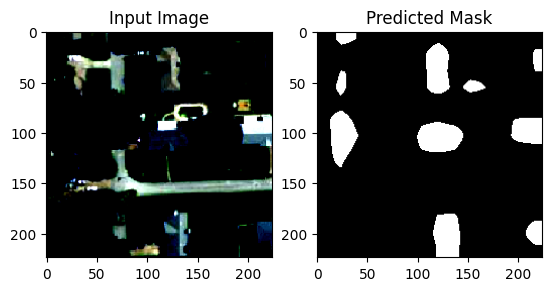

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


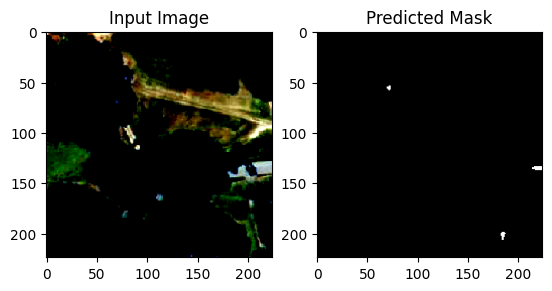

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


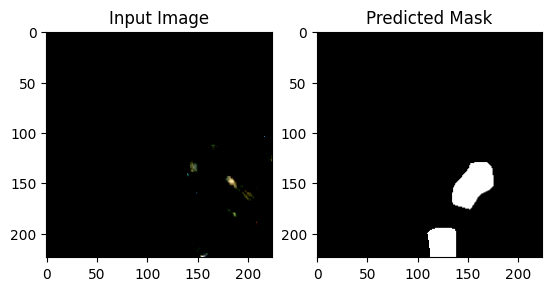

 29%|██▊       | 2/7 [00:06<00:14,  2.93s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


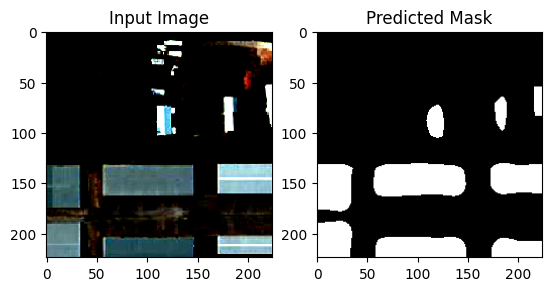

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


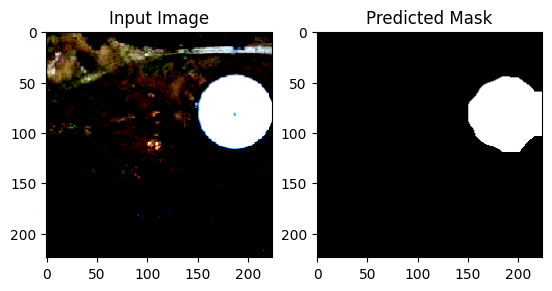

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


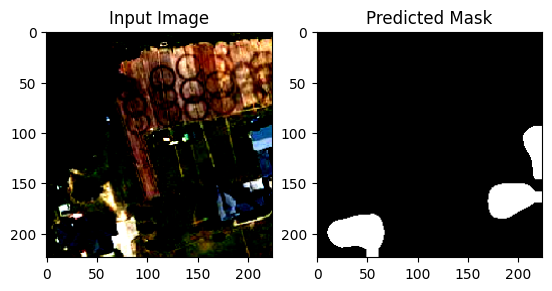

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


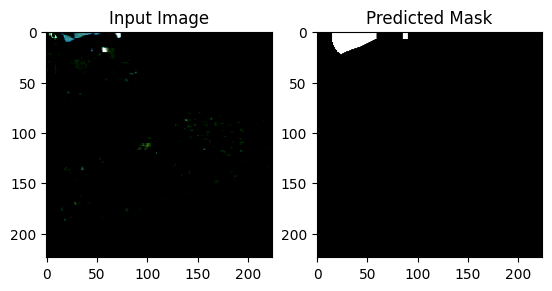

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


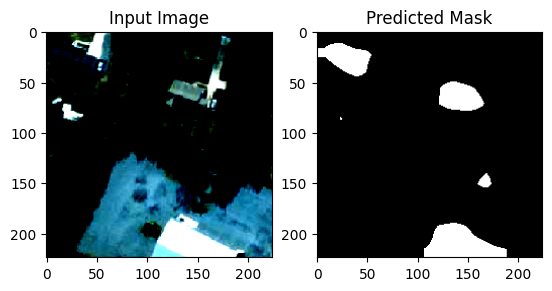

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


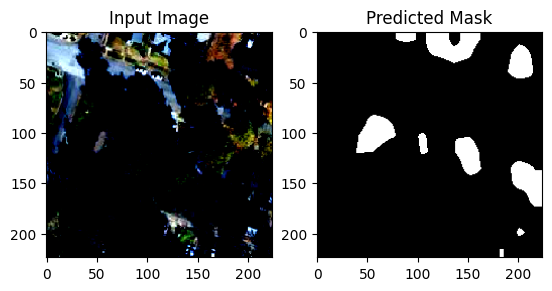

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


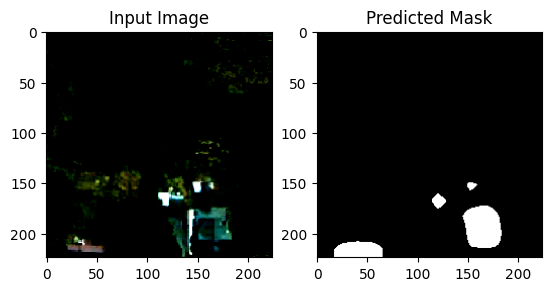

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


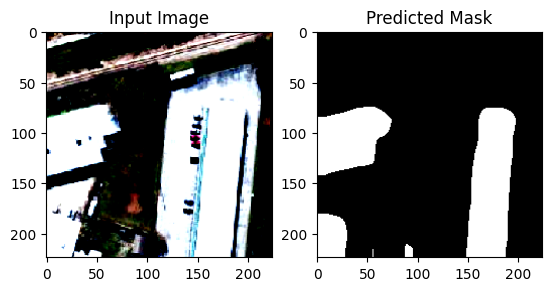

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


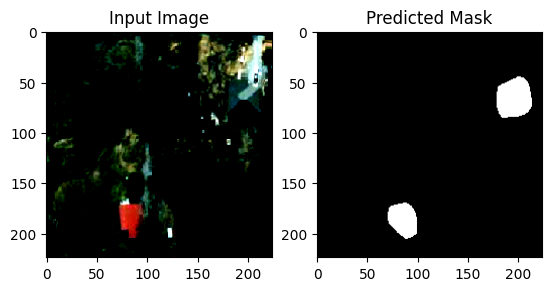

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


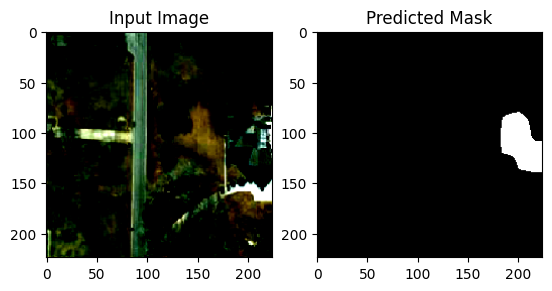

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


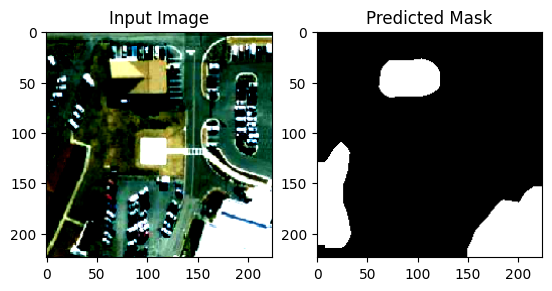

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


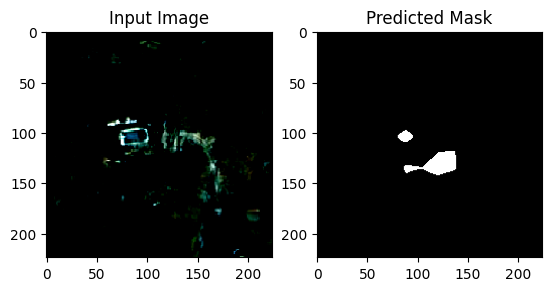

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


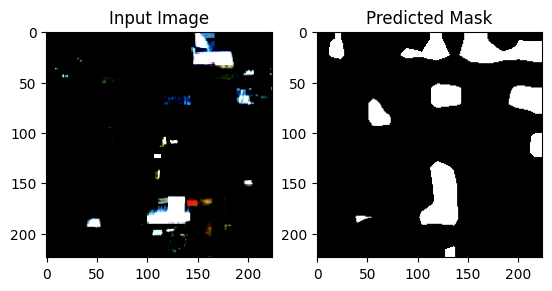

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


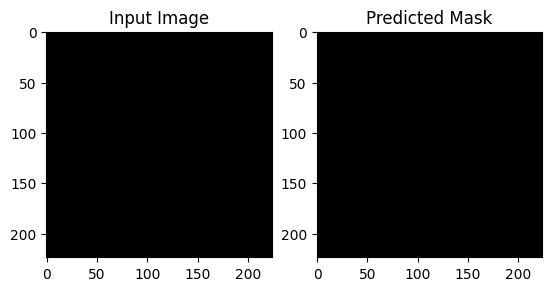

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


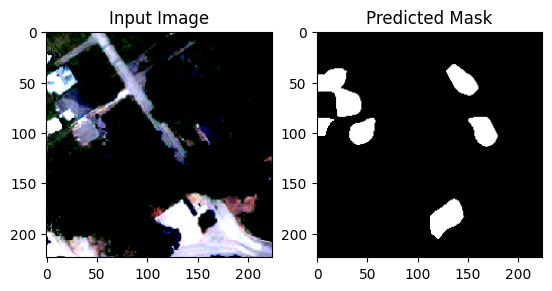

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


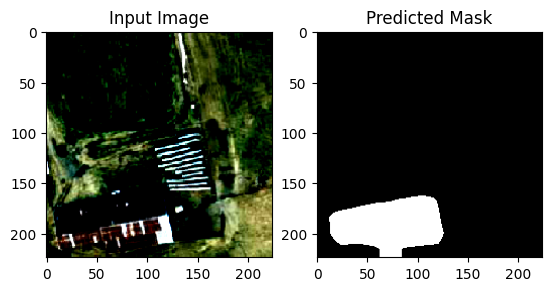

 43%|████▎     | 3/7 [00:08<00:11,  2.75s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


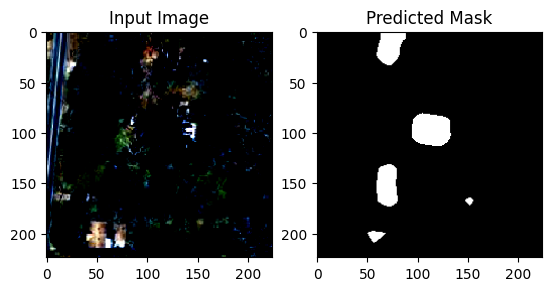

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


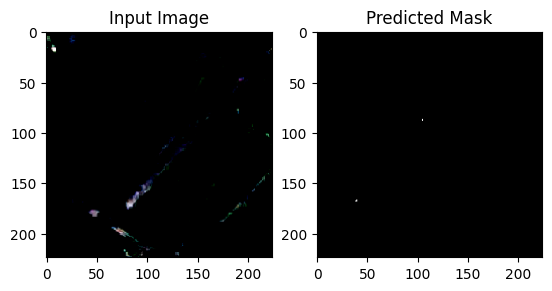

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


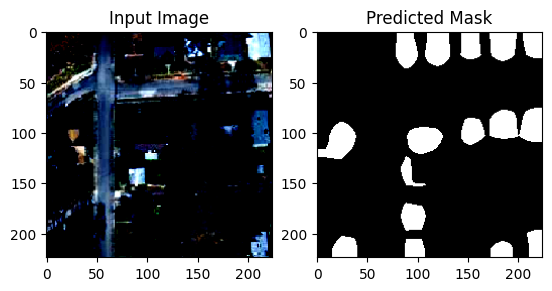

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


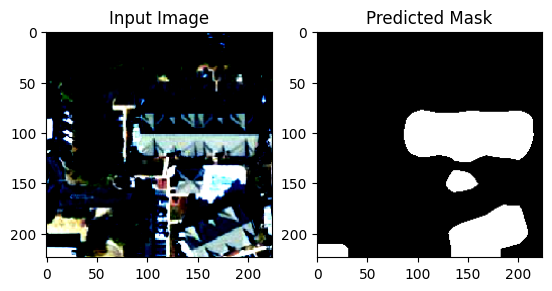

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


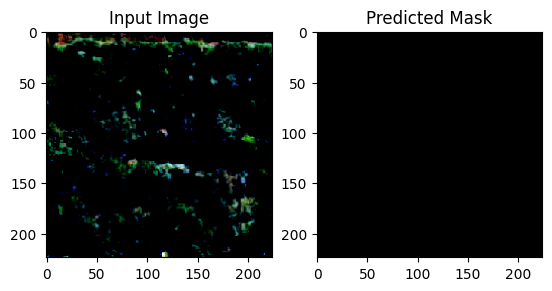

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


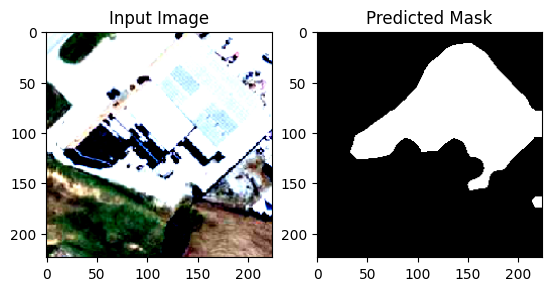

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


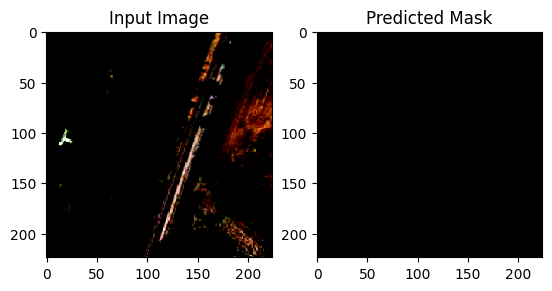

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


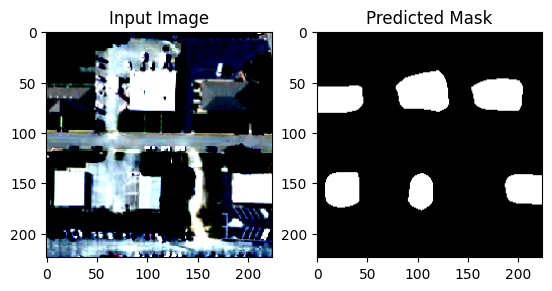

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


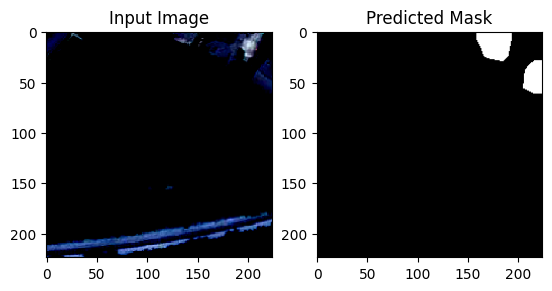

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


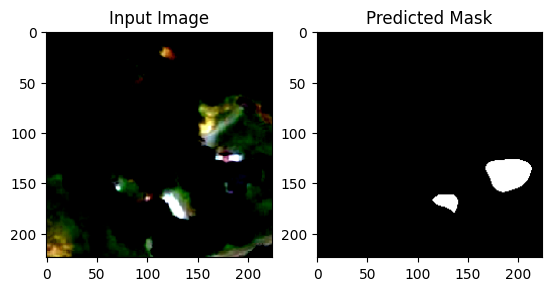

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


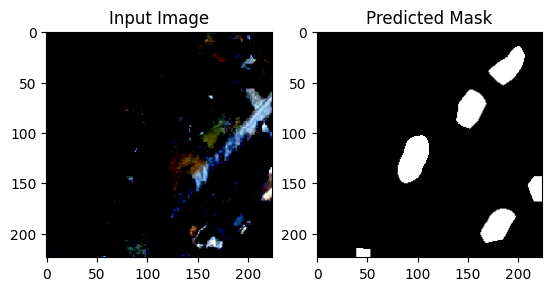

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


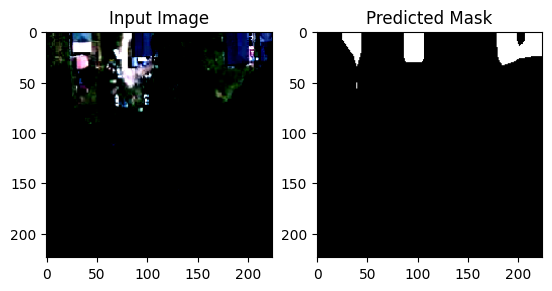

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


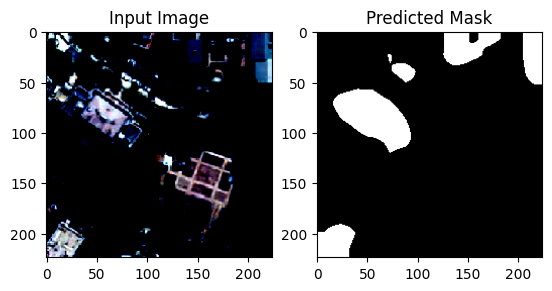

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


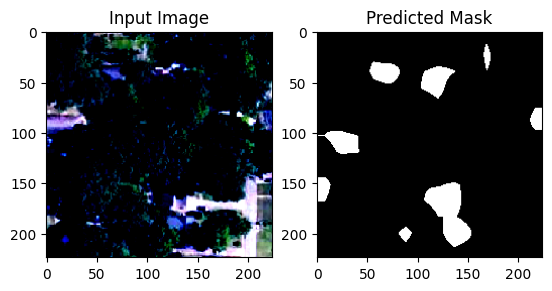

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


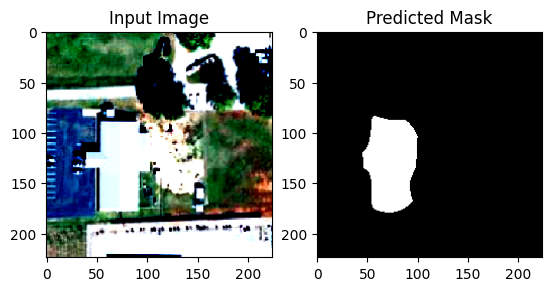

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


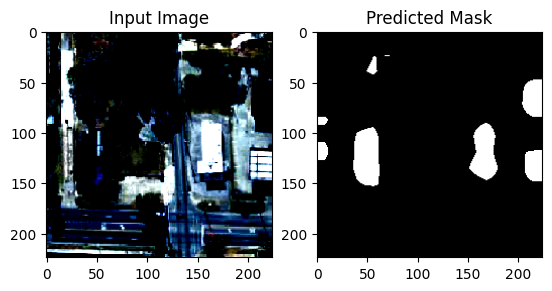

 57%|█████▋    | 4/7 [00:11<00:08,  2.68s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


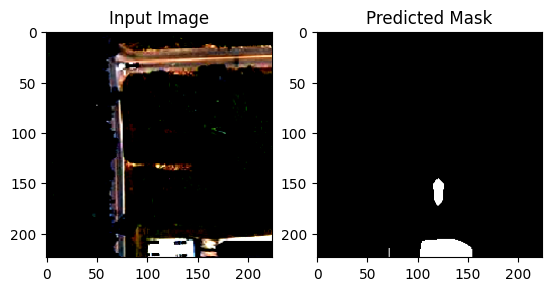

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


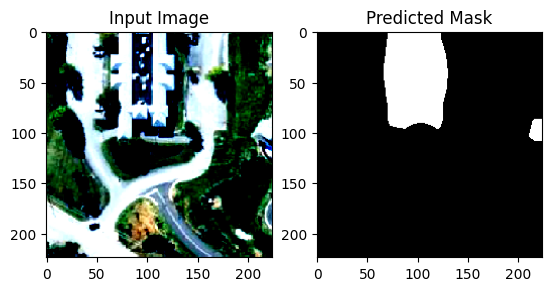

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


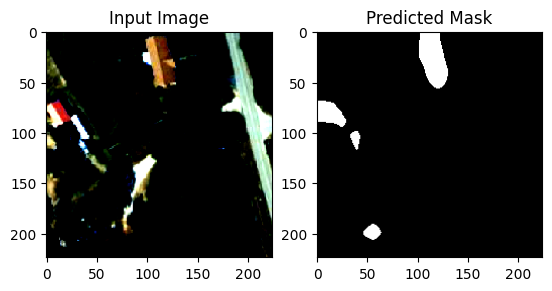

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


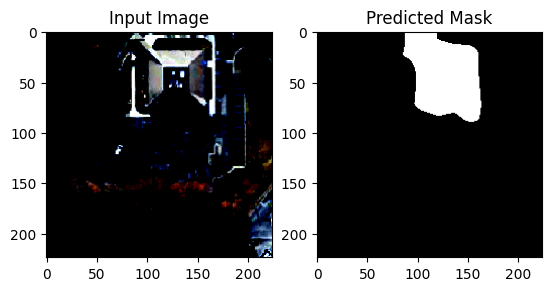

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


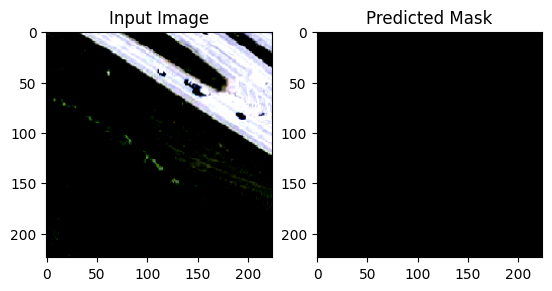

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


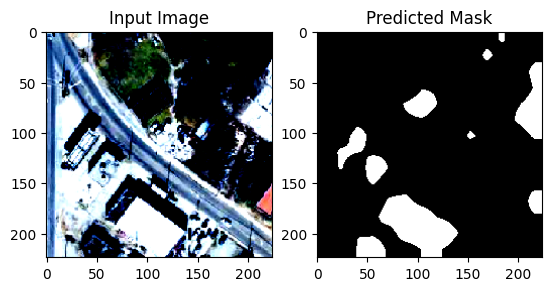

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


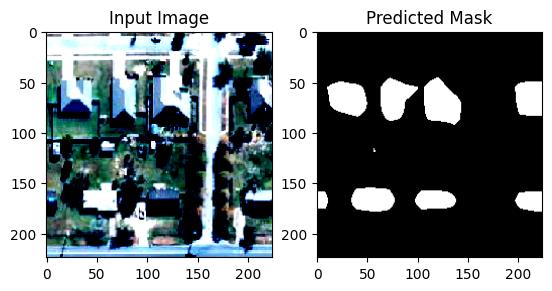

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


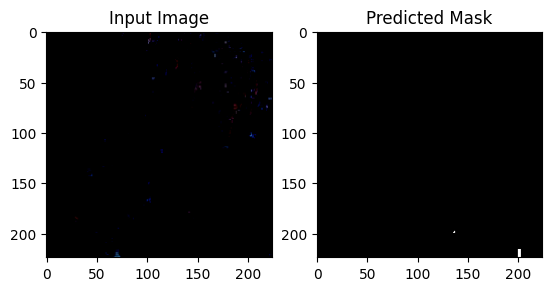

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


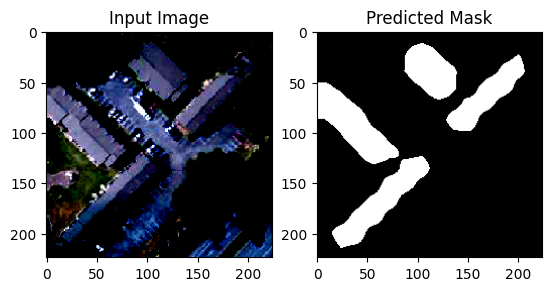

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


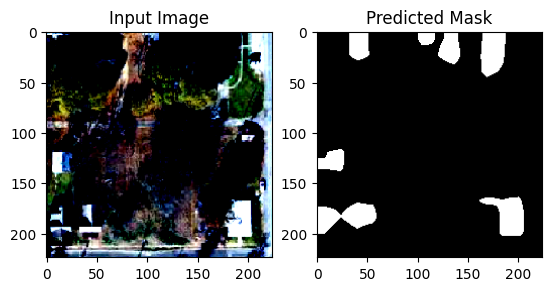

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


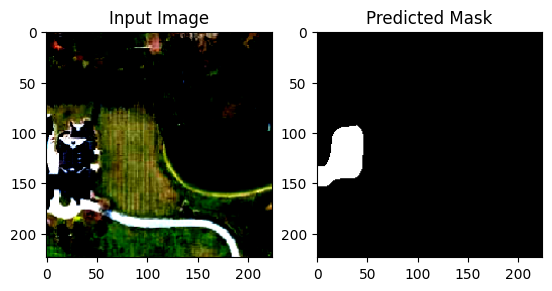

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


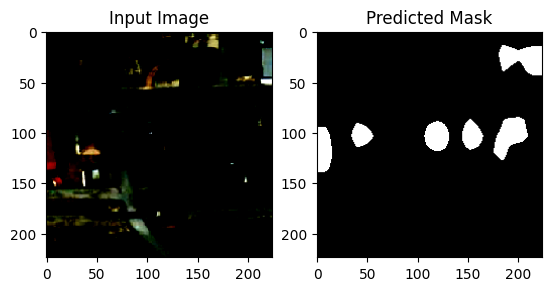

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


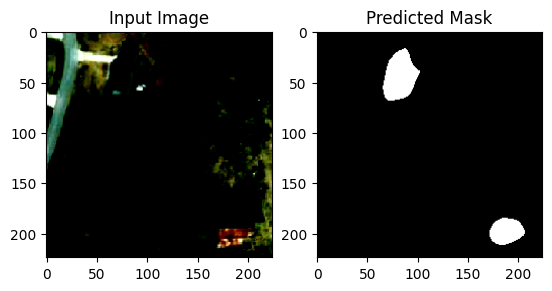

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


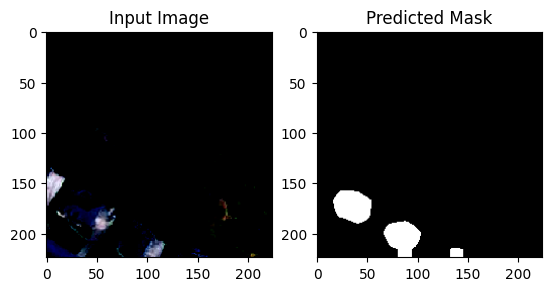

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


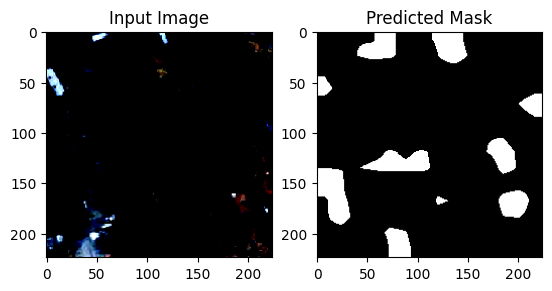

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


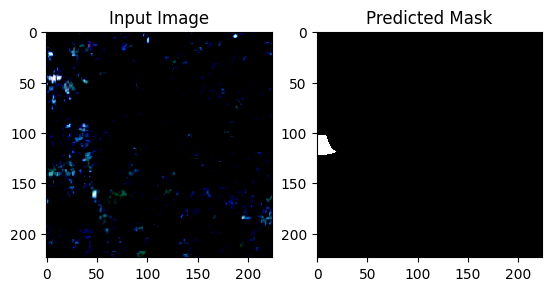

 71%|███████▏  | 5/7 [00:13<00:05,  2.65s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


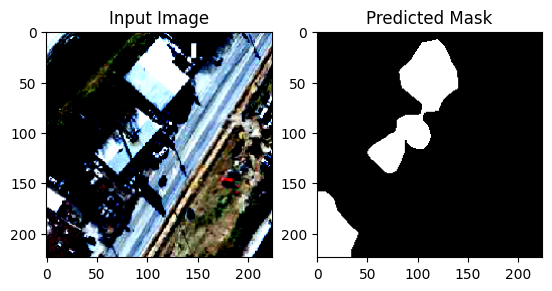

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


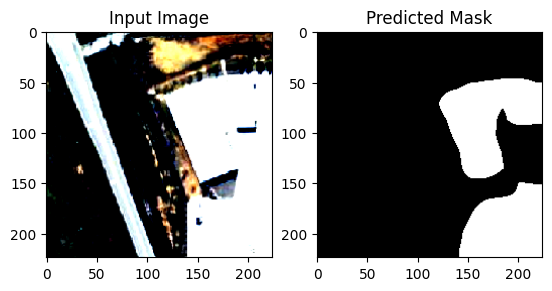

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


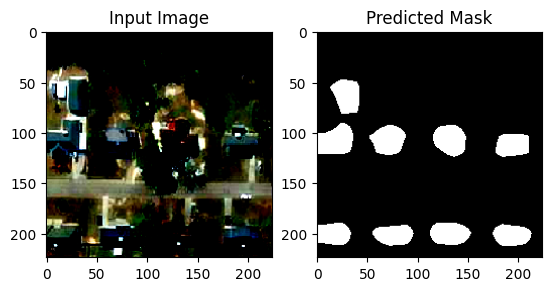

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


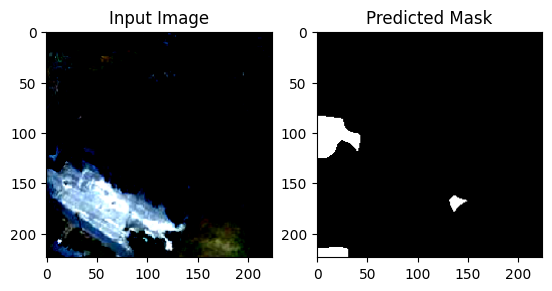

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


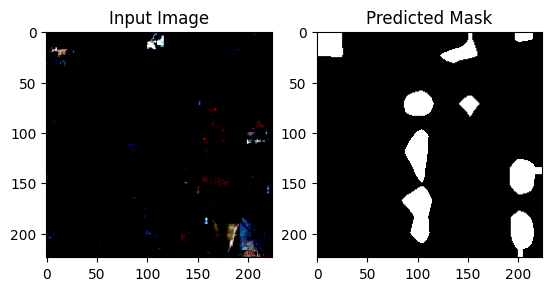

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


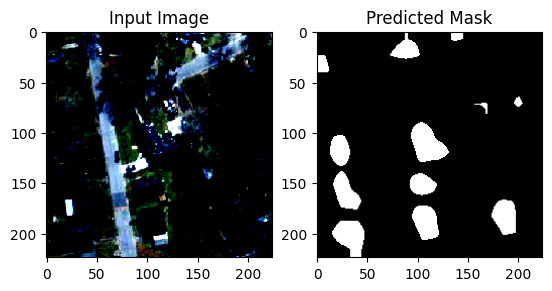

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


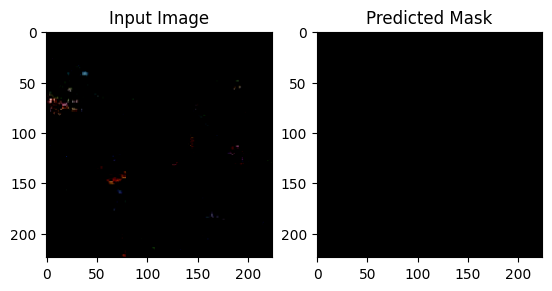

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


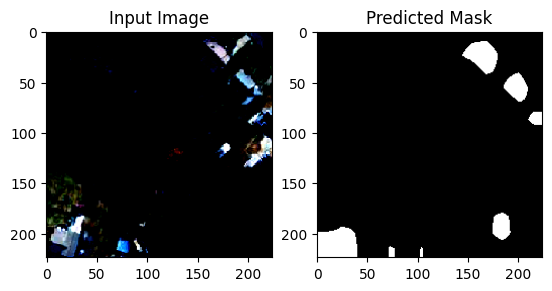

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


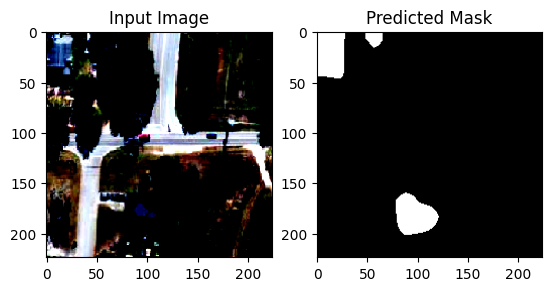

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


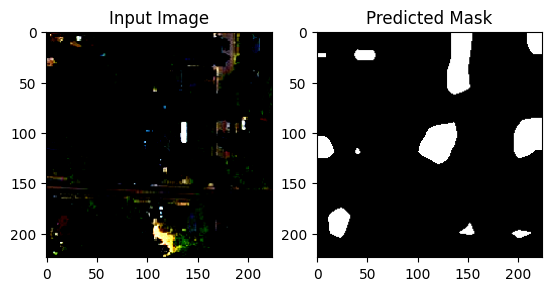

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


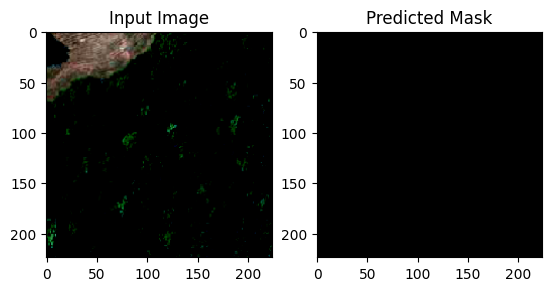

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


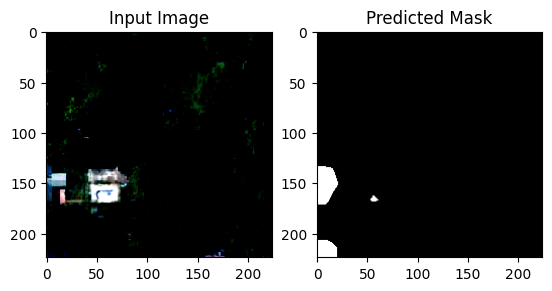

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


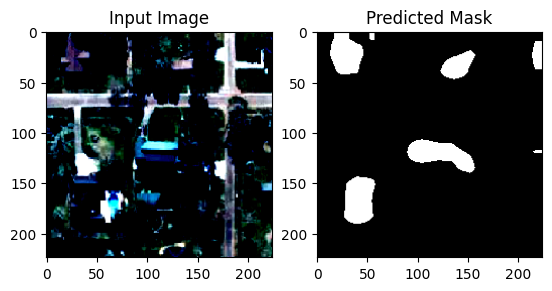

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


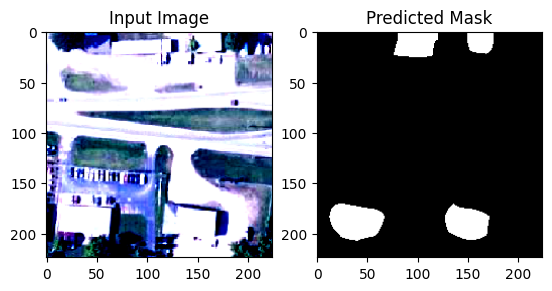

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


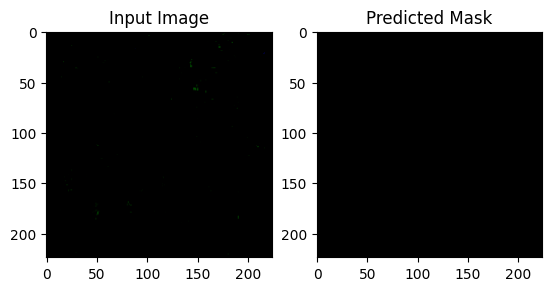

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


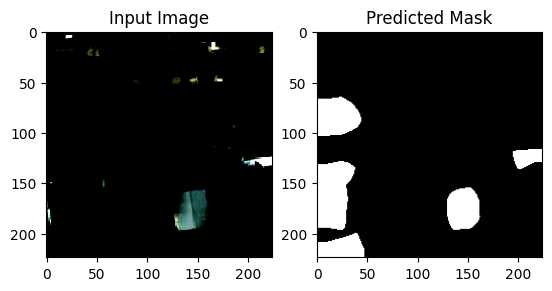

 86%|████████▌ | 6/7 [00:16<00:02,  2.66s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


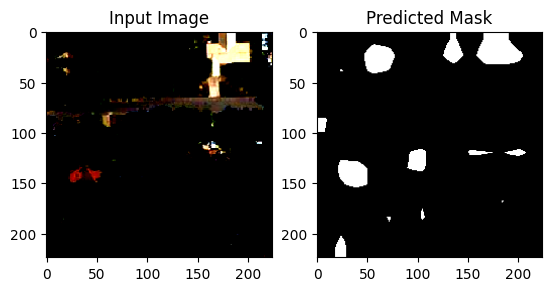

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


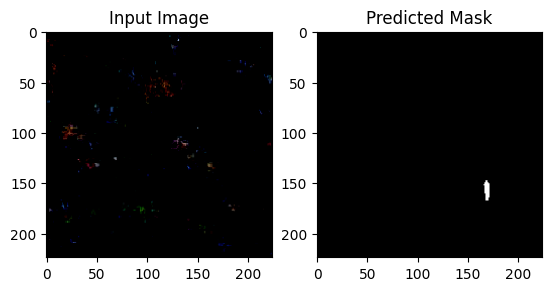

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


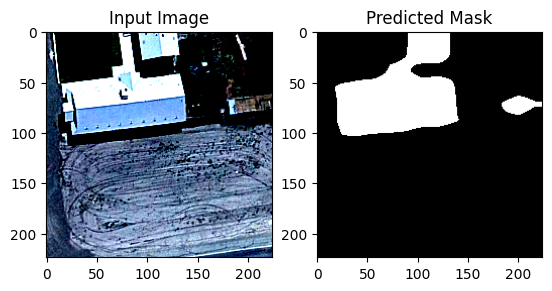

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


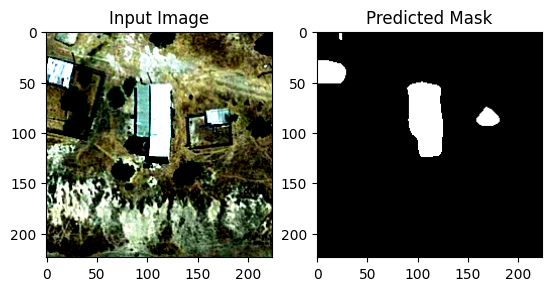

100%|██████████| 7/7 [00:17<00:00,  2.49s/it]


In [9]:
# 결과를 저장할 리스트 초기화
result = []

with torch.no_grad(): # 역전파 비활성화, 파라미터 업데이트 금지
    # print(len(test_dataloader))
    for images in tqdm(test_dataloader): # 데이터 로드
        images = images.float().to(device) 

        outputs = model(images)['out'] # 테스트 이미지 전달하여 예측 결과 얻음
        masks = torch.sigmoid(outputs).cpu().numpy() # outputs는 모델 예측 결과, 확률값으로 변환하기 위해 시그모이드 함수 적용한 후 각 픽셀 값을 0과 1사이의 확률값으로 변환하고, 넘파이 배열로 변환
        masks = np.squeeze(masks, axis=1) # 불필요한 차원 제거
        masks = (masks > 0.35).astype(np.uint8) # 최종 이진화 예측 마스크 얻음
        # print(len(images))
        for i in range(len(images)):
            mask_rle = rle_encode(masks[i]) # RLE로 변환, mask_rle에 인코딩 결과 저장
            if mask_rle == '':
                result.append(-1) # 빌딩 없으면 -1 저장
            else:
                result.append(mask_rle) # 아니면 mask_rle 저장

            visualized_image = images[i].cpu().numpy().transpose((1, 2, 0)) # 이미지 시각화하기 위해 넘파이 배열로 가져옴
            masks_visualized = masks[i] * 255 # 이진화 마스크로 변환

            plt.subplot(1, 2, 1)
            plt.imshow(visualized_image)
            plt.title("Input Image")

            plt.subplot(1, 2, 2)
            plt.imshow(masks_visualized, cmap='gray')
            plt.title("Predicted Mask")

            plt.show()

In [ ]:
print(len(result))

100


# Submission

In [10]:
submit = pd.read_csv('./validation_sample.csv')
submit['mask_rle'] = result

In [11]:
submit.to_csv('./validation_submit.csv', index=False)